<a href="https://colab.research.google.com/github/alisharifi2000/ImageRetrieval/blob/main/ImageRetrieval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# # #read all images and change size to 256 * 256
# from PIL import Image
 
# def resize_image(path,save_path):
#     im = Image.open(path)
#     im = im.resize((int(256), int(256)), Image.ANTIALIAS)
#     im.save(save_path)
#     im.close()

In [1]:

from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [3]:
# import glob

# paths = glob.glob('/gdrive/MyDrive/ImageRetrieval/animal_database/*/*/*.jpg',recursive = True)
# for path in paths:
#     resize_image(path,path)

# print('resize all images complete !')

In [4]:
# len(paths)

In [2]:
# train VAE AutoEncoder
# use encoder for making image features into latent space

import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from keras import backend as K
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense , Add, Input , Conv2D  ,MaxPooling2D ,AveragePooling2D ,Flatten , Lambda , UpSampling2D ,Conv2DTranspose ,Reshape 
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping , ModelCheckpoint , ReduceLROnPlateau
from tensorflow.keras.losses import mean_absolute_error
from random import shuffle
from keras.models import load_model
import glob

In [6]:
def sample_latent_features(distribution):
    distribution_mean, distribution_variance = distribution
    batch_size = tf.shape(distribution_variance)[0]
    random = tf.keras.backend.random_normal(shape=(batch_size, tf.shape(distribution_variance)[1]))
    return distribution_mean + tf.exp(0.5 * distribution_variance) * random

In [7]:
# VAE encoder 
'''
input shape = (256,256,3)
'''

input_shape = (256,256,3)

input_encoder = Input(input_shape,name = 'encoder_input')
encoder = Conv2D(16,(2,2),activation = 'relu',name = 'encoder_layer1')(input_encoder)
encoder = Conv2D(32,(2,2),activation = 'relu',name = 'encoder_layer2')(input_encoder)
encoder = AveragePooling2D(2,2 , name = 'encoder_layer3')(encoder)
encoder = Conv2D(32,(3,3),activation = 'relu',name = 'encoder_layer4')(encoder)
encoder = Conv2D(64,(3,3),activation = 'relu',name = 'encoder_layer5')(encoder)
encoder = Conv2D(64,(3,3),activation = 'relu',name = 'encoder_layer6')(encoder)
encoder = MaxPooling2D(3,3 , name = 'encoder_layer7')(encoder)
encoder = Conv2D(64,(4,4),activation = 'relu',name = 'encoder_layer8')(encoder)
encoder = Conv2D(64,(4,4),activation = 'relu',name = 'encoder_layer9')(encoder)
encoder = Conv2D(128,(4,4),activation = 'relu',name = 'encoder_layer10')(encoder)
encoder = AveragePooling2D(3,3, name = 'encoder_layer11')(encoder)
encoder = Flatten(name = 'encoder_layer12')(encoder)
encoder = Dense(512 , activation = 'relu', name = 'encoder_layer13')(encoder)

distribution_mean = Dense(512, name='mean')(encoder)
distribution_variance = Dense(512, name='log_variance')(encoder)

latent_encoding = Lambda(sample_latent_features , name = 'encoder_output')([distribution_mean, distribution_variance])
Encoder = Model(inputs= [input_encoder], outputs=[latent_encoding],name = 'Encoder')

#VAE decoder

'''
input shape = (512)
'''

input_shape = 512

input_decoder = Input(input_shape,name = 'decoder_input')
decoder = Reshape((4, 4, 32),name = 'decoder_layer1')(input_decoder)
decoder = Conv2DTranspose(32, (3,3), activation='relu' , name = 'decoder_layer2')(decoder)
decoder = UpSampling2D(2,name = 'decoder_layer3')(decoder)
decoder = Conv2DTranspose(32, (3,3), activation='relu' , name = 'decoder_layer4')(decoder)
decoder = UpSampling2D(2,name = 'decoder_layer5')(decoder)
decoder = Conv2DTranspose(32, (2,2), activation='relu' , name = 'decoder_layer6')(decoder)
decoder = UpSampling2D(2,name = 'decoder_layer7')(decoder)
decoder = Conv2DTranspose(64, (3,3), activation='relu' , name = 'decoder_layer8')(decoder)
decoder = Conv2DTranspose(64, (4,4), activation='relu' , name = 'decoder_layer9')(decoder)
decoder = Conv2DTranspose(64, (4,4), activation='relu' , name = 'decoder_layer10')(decoder)
decoder = UpSampling2D(4,name = 'decoder_layer11')(decoder)
decoder = Conv2D(3,(9,9), name = 'decoder_layer12' , activation= 'relu')(decoder)
Decoder = Model(inputs= [input_decoder], outputs=[decoder],name = 'Decoder')

Model: "VAE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
VAE_input (InputLayer)       [(None, 256, 256, 3)]     0         
_________________________________________________________________
Encoder (Functional)         (None, 512)               7406912   
_________________________________________________________________
Decoder (Functional)         (None, 256, 256, 3)       187875    
Total params: 7,594,787
Trainable params: 7,594,787
Non-trainable params: 0
_________________________________________________________________
None


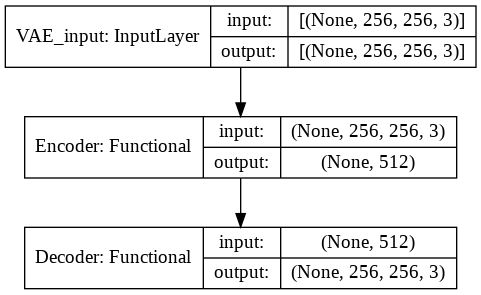

In [8]:
# VAE Model
VAE_input = Input((256,256,3),name = 'VAE_input')
VAE_latent = Encoder(VAE_input)
VAE_output = Decoder(VAE_latent)
VAE = Model(inputs= [VAE_input], outputs=[VAE_output],name = 'VAE')

print(VAE.summary())
plot_model(VAE, show_shapes=True)

In [9]:
'''
define perceptual_loss
'''

selected_layers = ['block1_conv1', 'block2_conv2',"block3_conv1","block3_conv3" ,'block4_conv1',
                   'block4_conv3','block5_conv1','block5_conv2','block5_conv3','block5_conv4']

selected_layer_weights = [1.0, 1.0 , 1.0 , 2.0 ,2.0,
                         3.0 , 3.0 ,4.0 ,4.0, 5.0]

vgg = VGG19(weights='imagenet', include_top=False, input_shape=(256,256,3))
vgg.trainable = False
outputs = [vgg.get_layer(l).output for l in selected_layers]
model = Model(vgg.input, outputs)

@tf.function
def perceptual_loss(input_image , reconstruct_image):
    h1_list = model(input_image)
    h2_list = model(reconstruct_image)

    rc_loss = 0.0

    img = K.batch_flatten(input_image)
    r_img = K.batch_flatten(reconstruct_image)
    r_error =  K.sum(K.abs(img - r_img), axis=-1) 

    for h1, h2, weight in zip(h1_list, h2_list, selected_layer_weights):

        h1 = K.batch_flatten(h1)
        h2 = K.batch_flatten(h2)
        rc_loss = rc_loss + weight * K.sum(K.abs(h1 - h2), axis=-1)
        rc_loss = rc_loss / 26

    rc_loss = (rc_loss / (sum(selected_layer_weights)))
    error = (rc_loss + r_error)/2

    return error 

In [10]:
rmsprop = RMSprop(learning_rate=0.00025 , momentum=0.99)
VAE.compile(loss= perceptual_loss, optimizer= rmsprop)

es = EarlyStopping(monitor="val_loss",
                   patience=15)

cp_callback = ModelCheckpoint(filepath='/gdrive/MyDrive/ImageRetrieval/Models/Best_RGB256_VAE.h5',
                              monitor='val_loss',
                              save_weights_only=True,
                              save_best_only=True,
                              verbose=1)

In [11]:
paths = glob.glob('/gdrive/MyDrive/ImageRetrieval/animal_database/*/*/*.jpg',recursive = True)
shuffle(paths)
len(paths)

1740

In [12]:
images = []
for path in paths :
    img = load_img(path)
    img = img_to_array(img)
    img = img.astype(np.float32)
    img = img/255.0
    images.append(img)
images = np.asarray(images)

In [13]:
VAE.fit(x=images,y=images,
    epochs=250,
    verbose = 1,
    batch_size = 32,
    validation_split = 0.3,
    callbacks = [es,cp_callback])

del images
del paths

Epoch 1/250
39/39 [==============================] - 66s 1s/step - loss: 38180.3684 - val_loss: 20750.4199

Epoch 00001: val_loss improved from inf to 20750.41992, saving model to /gdrive/MyDrive/ImageRetrieval/Models/Best_RGB256_VAE.h5
Epoch 2/250
39/39 [==============================] - 53s 1s/step - loss: 20674.4784 - val_loss: 21362.4160

Epoch 00002: val_loss did not improve from 20750.41992
Epoch 3/250
39/39 [==============================] - 53s 1s/step - loss: 20764.4820 - val_loss: 21133.2441

Epoch 00003: val_loss did not improve from 20750.41992
Epoch 4/250
39/39 [==============================] - 52s 1s/step - loss: 21451.0628 - val_loss: 20878.1992

Epoch 00004: val_loss did not improve from 20750.41992
Epoch 5/250
39/39 [==============================] - 52s 1s/step - loss: 20470.8386 - val_loss: 20492.9746

Epoch 00005: val_loss improved from 20750.41992 to 20492.97461, saving model to /gdrive/MyDrive/ImageRetrieval/Models/Best_RGB256_VAE.h5
Epoch 6/250
39/39 [==========

In [14]:
! ls '/gdrive/MyDrive/ImageRetrieval/Models/'

Best_RGB256_VAE.h5


In [15]:
VAE.save("/gdrive/MyDrive/ImageRetrieval/Models/RGB256_VAE.h5")
Encoder.save("/gdrive/MyDrive/ImageRetrieval/Models/RGB256_Encoder.h5")

In [16]:
VAE.save_weights('/gdrive/MyDrive/ImageRetrieval/Models/RGB256_VAE_weights.h5')
Encoder.save_weights('/gdrive/MyDrive/ImageRetrieval/Models/RGB256_Encoder_weights.h5')

In [17]:
! ls '/gdrive/MyDrive/ImageRetrieval/Models/'

Best_RGB256_VAE.h5  RGB256_Encoder_weights.h5  RGB256_VAE_weights.h5
RGB256_Encoder.h5   RGB256_VAE.h5


# save latent vector of RGB in pickle file

In [18]:
# VAE.load_weights('/gdrive/MyDrive/ImageRetrieval/Models/RGB256_VAE_weights.h5')
Encoder.load_weights('/gdrive/MyDrive/ImageRetrieval/Models/RGB256_Encoder_weights.h5')

In [19]:
paths = glob.glob('/gdrive/MyDrive/ImageRetrieval/animal_database/*/*/*.jpg',recursive = True)

In [20]:
counter = 0
data = {}
added = []

for path in paths :
    name = path.split('/')[-1].split('.')[0]
    class_name  = path.split('/')[-3]

    img = load_img(path)
    img = img_to_array(img)
    img = img.astype(np.float32)
    img = img/255.0
    img = [img]
    img = np.asarray(img)

    latent = Encoder(img).numpy().reshape(512)
    latent = np.nan_to_num(latent, nan=0)

    id = '{}-{}'.format(class_name,name)

    if id in added:
        print(path)
    else:
        data[id] = {'RGB_features':latent , 'Class':class_name}
        added.append(id)
        counter +=1

print(len(paths))
print(counter)

1740
1740


In [ ]:
# save RGB feature and class of images in pickle file
import pickle

with open('/gdrive/MyDrive/ImageRetrieval/features.pickle', 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('/gdrive/MyDrive/ImageRetrieval/features.pickle', 'rb') as handle:
#      print(len(pickle.load(handle).keys()))

In [ ]:
del paths
del data

# save representatives of each class by mean of features

In [23]:
classes = glob.glob('/gdrive/MyDrive/ImageRetrieval/animal_database/*',recursive = True)
list_class = []
for c in classes:
    c = c.split('/')[-1]
    list_class.append(c)

In [24]:
data = {}
for c in list_class:
    paths = glob.glob('/gdrive/MyDrive/ImageRetrieval/animal_database/{}/*/*.jpg'.format(c))
    sum = np.zeros(512,dtype=np.float32)
    for path in paths:
        img = load_img(path)
        img = img_to_array(img)
        img = img.astype(np.float32)
        img = img/255.0
        img = [img]
        img = np.asarray(img)
        latent = Encoder(img).numpy().reshape(512)
        latent = np.nan_to_num(latent, nan=0)
        sum = sum + latent
    sum = sum/len(paths)
    data[c] = {'RGB':sum}

In [ ]:
with open('/gdrive/MyDrive/ImageRetrieval/representatives.pickle', 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
del data

# HSI features

In [ ]:
## change image to HSI and then use AutoEncoder to reduce dimension

from skimage.color import rgb2hsv

In [ ]:
def sample_latent_features(distribution):
    distribution_mean, distribution_variance = distribution
    batch_size = tf.shape(distribution_variance)[0]
    random = tf.keras.backend.random_normal(shape=(batch_size, tf.shape(distribution_variance)[1]))
    return distribution_mean + tf.exp(0.5 * distribution_variance) * random

# VAE encoder 
'''
input shape = (256,256,3)
'''

input_shape = (256,256,3)

input_encoder = Input(input_shape,name = 'encoder_input')
encoder = Conv2D(16,(2,2),activation = 'relu',name = 'encoder_layer1')(input_encoder)
encoder = Conv2D(32,(2,2),activation = 'relu',name = 'encoder_layer2')(input_encoder)
encoder = AveragePooling2D(2,2 , name = 'encoder_layer3')(encoder)
encoder = Conv2D(32,(3,3),activation = 'relu',name = 'encoder_layer4')(encoder)
encoder = Conv2D(64,(3,3),activation = 'relu',name = 'encoder_layer5')(encoder)
encoder = Conv2D(64,(3,3),activation = 'relu',name = 'encoder_layer6')(encoder)
encoder = MaxPooling2D(3,3 , name = 'encoder_layer7')(encoder)
encoder = Conv2D(64,(4,4),activation = 'relu',name = 'encoder_layer8')(encoder)
encoder = Conv2D(64,(4,4),activation = 'relu',name = 'encoder_layer9')(encoder)
encoder = Conv2D(128,(4,4),activation = 'relu',name = 'encoder_layer10')(encoder)
encoder = AveragePooling2D(3,3, name = 'encoder_layer11')(encoder)
encoder = Flatten(name = 'encoder_layer12')(encoder)
encoder = Dense(512 , activation = 'relu', name = 'encoder_layer13')(encoder)

distribution_mean = Dense(512, name='mean')(encoder)
distribution_variance = Dense(512, name='log_variance')(encoder)

latent_encoding = Lambda(sample_latent_features , name = 'encoder_output')([distribution_mean, distribution_variance])
Encoder = Model(inputs= [input_encoder], outputs=[latent_encoding],name = 'Encoder')

#VAE decoder

'''
input shape = (128)
'''

input_shape = 512

input_decoder = Input(input_shape,name = 'decoder_input')
decoder = Reshape((4, 4, 32),name = 'decoder_layer1')(input_decoder)
decoder = Conv2DTranspose(32, (3,3), activation='relu' , name = 'decoder_layer2')(decoder)
decoder = UpSampling2D(2,name = 'decoder_layer3')(decoder)
decoder = Conv2DTranspose(32, (3,3), activation='relu' , name = 'decoder_layer4')(decoder)
decoder = UpSampling2D(2,name = 'decoder_layer5')(decoder)
decoder = Conv2DTranspose(32, (2,2), activation='relu' , name = 'decoder_layer6')(decoder)
decoder = UpSampling2D(2,name = 'decoder_layer7')(decoder)
decoder = Conv2DTranspose(64, (3,3), activation='relu' , name = 'decoder_layer8')(decoder)
decoder = Conv2DTranspose(64, (4,4), activation='relu' , name = 'decoder_layer9')(decoder)
decoder = Conv2DTranspose(64, (4,4), activation='relu' , name = 'decoder_layer10')(decoder)
decoder = UpSampling2D(4,name = 'decoder_layer11')(decoder)
decoder = Conv2D(3,(9,9), name = 'decoder_layer12' , activation= 'relu')(decoder)
Decoder = Model(inputs= [input_decoder], outputs=[decoder],name = 'Decoder')


# VAE Model
VAE_input = Input((256,256,3),name = 'VAE_input')
VAE_latent = Encoder(VAE_input)
VAE_output = Decoder(VAE_latent)
VAE = Model(inputs= [VAE_input], outputs=[VAE_output],name = 'VAE')

In [ ]:
'''
define perceptual_loss
'''

selected_layers = ['block1_conv1', 'block2_conv2',"block3_conv1","block3_conv3" ,'block4_conv1',
                   'block4_conv3','block5_conv1','block5_conv2','block5_conv3','block5_conv4']

selected_layer_weights = [1.0, 1.0 , 1.0 , 2.0 ,2.0,
                         3.0 , 3.0 ,4.0 ,4.0, 5.0]

vgg = VGG19(weights='imagenet', include_top=False, input_shape=(256,256,3))
vgg.trainable = False
outputs = [vgg.get_layer(l).output for l in selected_layers]
model = Model(vgg.input, outputs)

@tf.function
def perceptual_loss(input_image , reconstruct_image):
    h1_list = model(input_image)
    h2_list = model(reconstruct_image)

    rc_loss = 0.0

    img = K.batch_flatten(input_image)
    r_img = K.batch_flatten(reconstruct_image)
    r_error =  K.sum(K.abs(img - r_img), axis=-1) 

    for h1, h2, weight in zip(h1_list, h2_list, selected_layer_weights):

        h1 = K.batch_flatten(h1)
        h2 = K.batch_flatten(h2)
        rc_loss = rc_loss + weight * K.sum(K.abs(h1 - h2), axis=-1)
        rc_loss = rc_loss / 10

    rc_loss = (rc_loss / 26.0)
    error = (rc_loss + r_error)/2

    return error 

In [ ]:
# perceputal loss good for RGB loss is so BIG!!!
rmsprop = RMSprop(learning_rate=0.00025 , momentum=0.99)
VAE.compile(loss= perceptual_loss, optimizer= rmsprop)

es = EarlyStopping(monitor="val_loss",
                   patience=15)

cp_callback = ModelCheckpoint(filepath='/gdrive/MyDrive/ImageRetrieval/Models/Best_HSI256_VAE.h5',
                              monitor='val_loss',
                              save_weights_only=True,
                              save_best_only=True,
                              verbose=1)

In [31]:
paths = glob.glob('/gdrive/MyDrive/ImageRetrieval/animal_database/*/*/*.jpg',recursive = True)
shuffle(paths)
len(paths)

1740

In [ ]:
images = []
for path in paths :
    img = load_img(path)
    img = img_to_array(img)
    hsv_img = rgb2hsv(img)
    hsv_img[:,:,2] = hsv_img[:,:,2]/255.0
    hsv_img = hsv_img.astype(np.float32)
    images.append(hsv_img)
images = np.asarray(images)

In [33]:
VAE.fit(x=images,y=images,
    epochs=250,
    verbose = 1,
    batch_size = 32,
    validation_split = 0.3,
    callbacks = [es,cp_callback])

Epoch 1/250
39/39 [==============================] - 56s 1s/step - loss: 25113.6453 - val_loss: 20260.2188

Epoch 00001: val_loss improved from inf to 20260.21875, saving model to /gdrive/MyDrive/ImageRetrieval/Models/Best_HSI256_VAE.h5
Epoch 2/250
39/39 [==============================] - 53s 1s/step - loss: 21305.9569 - val_loss: 8248470528.0000

Epoch 00002: val_loss did not improve from 20260.21875
Epoch 3/250
39/39 [==============================] - 52s 1s/step - loss: 1324423549262502124039700480.0000 - val_loss: 36750.4297

Epoch 00003: val_loss did not improve from 20260.21875
Epoch 4/250
39/39 [==============================] - 51s 1s/step - loss: 36637.9330 - val_loss: 36750.4297

Epoch 00004: val_loss did not improve from 20260.21875
Epoch 5/250
39/39 [==============================] - 52s 1s/step - loss: 36644.3567 - val_loss: 36750.4297

Epoch 00005: val_loss did not improve from 20260.21875
Epoch 6/250
39/39 [==============================] - 52s 1s/step - loss: 36625.7731

In [ ]:
del images
del paths

In [ ]:
VAE.save("/gdrive/MyDrive/ImageRetrieval/Models/HSI256_VAE.h5")
Encoder.save("/gdrive/MyDrive/ImageRetrieval/Models/HSI256_Encoder.h5")

In [ ]:
VAE.save_weights('/gdrive/MyDrive/ImageRetrieval/Models/HSI256_VAE_weights.h5')
Encoder.save_weights('/gdrive/MyDrive/ImageRetrieval/Models/HSI256_Encoder_weights.h5')

In [ ]:
Encoder.load_weights('/gdrive/MyDrive/ImageRetrieval/Models/HSI256_Encoder.h5')

In [ ]:
handle = open('/gdrive/MyDrive/ImageRetrieval/features.pickle', 'rb')
data = pickle.load(handle)
ids = list(data.keys())
for id in ids:
    c = id.split('-')[0]
    name = id.split('-')[1]

    path = '/gdrive/MyDrive/ImageRetrieval/animal_database/{}/original/{}.jpg'.format(c,name)
    img = load_img(path)
    img = img_to_array(img)
    hsv_img = rgb2hsv(img)
    hsv_img[:,:,2] = hsv_img[:,:,2]/255.0
    hsv_img = hsv_img.astype(np.float64).reshape(1,256,256,3)
    latent = Encoder(hsv_img).numpy().reshape(512)
    latent = np.nan_to_num(latent, nan=0)
    data[id].update({'HSI_features':latent})

In [ ]:
data[list(data.keys())[0]]

In [ ]:
with open('/gdrive/MyDrive/ImageRetrieval/features1.pickle', 'wb') as handle1:
    pickle.dump(data, handle1, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
handle = open('/gdrive/MyDrive/ImageRetrieval/representatives.pickle', 'rb')
data = pickle.load(handle)
ids = list(data.keys())

for id in ids:
    paths = glob.glob('/gdrive/MyDrive/ImageRetrieval/animal_database/{}/original/*.jpg'.format(c))
    sum = np.zeros(512,dtype=np.float32)
    for path in paths:
        img = load_img(path)
        img = img_to_array(img)
        hsv_img = rgb2hsv(img)
        hsv_img[:,:,2] = hsv_img[:,:,2]/255.0
        hsv_img = hsv_img.astype(np.float32).reshape(1,256,256,3)
        latent = Encoder(hsv_img).numpy().reshape(512)
        latent = np.nan_to_num(latent, nan=0)
        sum = sum + latent
    sum = (sum / len(paths))
    data[id].update({'HSI':sum})

In [ ]:
data['lion']

In [ ]:
with open('/gdrive/MyDrive/ImageRetrieval/representatives1.pickle', 'wb') as handle1:
    pickle.dump(data, handle1, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
del data

# LAB color

In [3]:
from skimage.color import rgb2lab

In [4]:
def sample_latent_features(distribution):
    distribution_mean, distribution_variance = distribution
    batch_size = tf.shape(distribution_variance)[0]
    random = tf.keras.backend.random_normal(shape=(batch_size, tf.shape(distribution_variance)[1]))
    return distribution_mean + tf.exp(0.5 * distribution_variance) * random

# VAE encoder 
'''
input shape = (256,256,3)
'''

input_shape = (256,256,3)

input_encoder = Input(input_shape,name = 'encoder_input')
encoder = Conv2D(16,(2,2),activation = 'relu',name = 'encoder_layer1')(input_encoder)
encoder = Conv2D(32,(2,2),activation = 'relu',name = 'encoder_layer2')(input_encoder)
encoder = AveragePooling2D(2,2 , name = 'encoder_layer3')(encoder)
encoder = Conv2D(32,(3,3),activation = 'relu',name = 'encoder_layer4')(encoder)
encoder = Conv2D(64,(3,3),activation = 'relu',name = 'encoder_layer5')(encoder)
encoder = Conv2D(64,(3,3),activation = 'relu',name = 'encoder_layer6')(encoder)
encoder = MaxPooling2D(3,3 , name = 'encoder_layer7')(encoder)
encoder = Conv2D(64,(4,4),activation = 'relu',name = 'encoder_layer8')(encoder)
encoder = Conv2D(64,(4,4),activation = 'relu',name = 'encoder_layer9')(encoder)
encoder = Conv2D(128,(4,4),activation = 'relu',name = 'encoder_layer10')(encoder)
encoder = AveragePooling2D(3,3, name = 'encoder_layer11')(encoder)
encoder = Flatten(name = 'encoder_layer12')(encoder)
encoder = Dense(512 , activation = 'relu', name = 'encoder_layer13')(encoder)

distribution_mean = Dense(512, name='mean')(encoder)
distribution_variance = Dense(512, name='log_variance')(encoder)

latent_encoding = Lambda(sample_latent_features , name = 'encoder_output')([distribution_mean, distribution_variance])
Encoder = Model(inputs= [input_encoder], outputs=[latent_encoding],name = 'Encoder')

#VAE decoder

'''
input shape = (128)
'''

input_shape = 512

input_decoder = Input(input_shape,name = 'decoder_input')
decoder = Reshape((4, 4, 32),name = 'decoder_layer1')(input_decoder)
decoder = Conv2DTranspose(32, (3,3), activation='relu' , name = 'decoder_layer2')(decoder)
decoder = UpSampling2D(2,name = 'decoder_layer3')(decoder)
decoder = Conv2DTranspose(32, (3,3), activation='relu' , name = 'decoder_layer4')(decoder)
decoder = UpSampling2D(2,name = 'decoder_layer5')(decoder)
decoder = Conv2DTranspose(32, (2,2), activation='relu' , name = 'decoder_layer6')(decoder)
decoder = UpSampling2D(2,name = 'decoder_layer7')(decoder)
decoder = Conv2DTranspose(64, (3,3), activation='relu' , name = 'decoder_layer8')(decoder)
decoder = Conv2DTranspose(64, (4,4), activation='relu' , name = 'decoder_layer9')(decoder)
decoder = Conv2DTranspose(64, (4,4), activation='relu' , name = 'decoder_layer10')(decoder)
decoder = UpSampling2D(4,name = 'decoder_layer11')(decoder)
decoder = Conv2D(3,(9,9), name = 'decoder_layer12' , activation= 'relu')(decoder)
Decoder = Model(inputs= [input_decoder], outputs=[decoder],name = 'Decoder')


# VAE Model
VAE_input = Input((256,256,3),name = 'VAE_input')
VAE_latent = Encoder(VAE_input)
VAE_output = Decoder(VAE_latent)
VAE = Model(inputs= [VAE_input], outputs=[VAE_output],name = 'VAE')

In [5]:
rmsprop = RMSprop(learning_rate=0.00025 , momentum=0.99)
VAE.compile(loss= 'mse', optimizer= rmsprop)

es = EarlyStopping(monitor="val_loss",
                   patience=15)

cp_callback = ModelCheckpoint(filepath='/gdrive/MyDrive/ImageRetrieval/Models/Best_LAB256_VAE.h5',
                              monitor='val_loss',
                              save_weights_only=True,
                              save_best_only=True,
                              verbose=1)

In [6]:
paths = glob.glob('/gdrive/MyDrive/ImageRetrieval/animal_database/*/*/*.jpg',recursive = True)
shuffle(paths)
len(paths)

1740

In [7]:
images = []
for path in paths :
    img = load_img(path)
    img = img_to_array(img)
    lab_img = rgb2lab(img)
    lab_img = lab_img.astype(np.float64)
    images.append(lab_img)
images = np.asarray(images)

VAE.fit(x=images,y=images,
    epochs=250,
    verbose = 1,
    batch_size = 32,
    validation_split = 0.3,
    callbacks = [es,cp_callback])

Epoch 1/250
39/39 [==============================] - 24s 486ms/step - loss: inf - val_loss: 10054937.0000

Epoch 00001: val_loss improved from inf to 10054937.00000, saving model to /gdrive/MyDrive/ImageRetrieval/Models/Best_LAB256_VAE.h5
Epoch 2/250
39/39 [==============================] - 18s 452ms/step - loss: 10083185.1250 - val_loss: 10054937.0000

Epoch 00002: val_loss did not improve from 10054937.00000
Epoch 3/250
39/39 [==============================] - 18s 459ms/step - loss: 10031264.6750 - val_loss: 10054937.0000

Epoch 00003: val_loss did not improve from 10054937.00000
Epoch 4/250
39/39 [==============================] - 18s 467ms/step - loss: 9994820.1000 - val_loss: 10054937.0000

Epoch 00004: val_loss did not improve from 10054937.00000
Epoch 5/250
39/39 [==============================] - 18s 465ms/step - loss: 9869892.5750 - val_loss: 10054937.0000

Epoch 00005: val_loss did not improve from 10054937.00000
Epoch 6/250
39/39 [==============================] - 18s 458ms/

In [8]:
del images
del paths

In [9]:
VAE.save("/gdrive/MyDrive/ImageRetrieval/Models/LAB256_VAE.h5")
Encoder.save("/gdrive/MyDrive/ImageRetrieval/Models/LAB256_Encoder.h5")

In [10]:
VAE.save_weights('/gdrive/MyDrive/ImageRetrieval/Models/LAB256_VAE_weights.h5')
Encoder.save_weights('/gdrive/MyDrive/ImageRetrieval/Models/LAB256_Encoder_weights.h5')

In [11]:
Encoder.load_weights('/gdrive/MyDrive/ImageRetrieval/Models/LAB256_Encoder.h5')

In [13]:
import pickle

In [14]:
handle = open('/gdrive/MyDrive/ImageRetrieval/features1.pickle', 'rb')
data = pickle.load(handle)
ids = list(data.keys())
for id in ids:
    c = id.split('-')[0]
    name = id.split('-')[1]

    path = '/gdrive/MyDrive/ImageRetrieval/animal_database/{}/original/{}.jpg'.format(c,name)
    img = load_img(path)
    img = img_to_array(img)
    lab_img = rgb2lab(img)
    lab_img = lab_img.astype(np.float32).reshape(1,256,256,3)
    latent = Encoder(lab_img).numpy().reshape(512)
    latent = np.nan_to_num(latent, nan=0)
    data[id].update({'LAB_features':latent})

In [15]:
data[list(data.keys())[0]]

{'Class': 'bear',
 'HSI_features': array([-6.63807154e-01,  1.36784685e+00,  0.00000000e+00, -7.34291673e-01,
         0.00000000e+00,  5.72505832e-01,  9.35396373e-01,  0.00000000e+00,
        -8.25669765e-02, -1.28590107e-01,  1.71663332e+00,  4.50711221e-01,
        -1.69693708e-01, -4.94645894e-01,  4.72525656e-02, -3.00285399e-01,
         6.18066669e-01,  2.50676703e+00,  2.77921510e+00, -1.17348182e+00,
        -3.71253967e-01, -7.16359496e-01,  5.26121724e-03,  0.00000000e+00,
         2.69489527e-01, -1.80560037e-01, -6.76683068e-01,  9.21367645e-01,
         3.03413421e-01,  3.01472843e-01,  0.00000000e+00,  5.32038331e-01,
         4.16582495e-01,  1.23158753e-01,  0.00000000e+00, -1.21855974e-01,
         0.00000000e+00, -8.97805572e-01,  2.86112368e-01,  0.00000000e+00,
         5.58204889e-01, -5.79586685e-01, -1.08660984e+00, -4.07155752e-01,
         1.99116087e+00, -2.20877004e+00, -8.53803575e-01, -7.85841048e-01,
        -9.00099218e-01, -6.73985630e-02,  8.08828950e

In [16]:
with open('/gdrive/MyDrive/ImageRetrieval/features2.pickle', 'wb') as handle1:
    pickle.dump(data, handle1, protocol=pickle.HIGHEST_PROTOCOL)

In [17]:
handle = open('/gdrive/MyDrive/ImageRetrieval/representatives1.pickle', 'rb')
data = pickle.load(handle)
ids = list(data.keys())

for id in ids:
    paths = glob.glob('/gdrive/MyDrive/ImageRetrieval/animal_database/{}/original/*.jpg'.format(c))
    sum = np.zeros(512,dtype=np.float32)
    for path in paths:
        img = load_img(path)
        img = img_to_array(img)
        lab_img = rgb2lab(img)
        lab_img = lab_img.astype(np.float32).reshape(1,256,256,3)
        latent = Encoder(lab_img).numpy().reshape(512)
        latent = np.nan_to_num(latent, nan=0)
        sum = sum + latent
    sum = (sum / len(paths))
    data[id].update({'LAB':sum})

In [18]:
data['lion']

{'HSI': array([ 3.04834723e-01,  1.50192127e-01,  0.00000000e+00,  1.37419671e-01,
         0.00000000e+00, -1.61973089e-01,  1.75580949e-01,  0.00000000e+00,
         2.83204526e-01, -7.71289226e-03,  2.48934239e-01, -3.11984062e-01,
         3.10745895e-01, -5.08565158e-02, -1.27462134e-01, -4.33359921e-01,
        -9.24695656e-02,  5.60985506e-01,  3.70235503e-01,  3.13336581e-01,
        -1.99281782e-01, -2.16220662e-01,  2.54495405e-02,  0.00000000e+00,
         3.86522770e-01, -6.00906491e-01, -2.85507113e-01, -3.66609186e-01,
        -1.05007321e-01, -1.02617517e-01,  0.00000000e+00, -3.62523824e-01,
         1.63555443e-01,  2.51111954e-01,  0.00000000e+00, -5.54819033e-02,
         0.00000000e+00, -4.02367175e-01,  2.20347658e-01,  0.00000000e+00,
        -1.20031282e-01, -1.04930170e-01,  8.41172263e-02, -4.14995670e-01,
         2.27337062e-01, -4.24346417e-01, -3.63828838e-01,  2.24526022e-02,
         1.11575685e-01,  1.82975873e-01,  5.65154016e-01, -1.54471800e-01,
     

In [19]:
with open('/gdrive/MyDrive/ImageRetrieval/representatives2.pickle', 'wb') as handle1:
    pickle.dump(data, handle1, protocol=pickle.HIGHEST_PROTOCOL)

In [20]:
del data

# XYZ color

In [41]:
from skimage.color import rgb2xyz

In [42]:
def sample_latent_features(distribution):
    distribution_mean, distribution_variance = distribution
    batch_size = tf.shape(distribution_variance)[0]
    random = tf.keras.backend.random_normal(shape=(batch_size, tf.shape(distribution_variance)[1]))
    return distribution_mean + tf.exp(0.5 * distribution_variance) * random

# VAE encoder 
'''
input shape = (256,256,3)
'''

input_shape = (256,256,3)

input_encoder = Input(input_shape,name = 'encoder_input')
encoder = Conv2D(16,(2,2),activation = 'relu',name = 'encoder_layer1')(input_encoder)
encoder = Conv2D(32,(2,2),activation = 'relu',name = 'encoder_layer2')(input_encoder)
encoder = AveragePooling2D(2,2 , name = 'encoder_layer3')(encoder)
encoder = Conv2D(32,(3,3),activation = 'relu',name = 'encoder_layer4')(encoder)
encoder = Conv2D(64,(3,3),activation = 'relu',name = 'encoder_layer5')(encoder)
encoder = Conv2D(64,(3,3),activation = 'relu',name = 'encoder_layer6')(encoder)
encoder = MaxPooling2D(3,3 , name = 'encoder_layer7')(encoder)
encoder = Conv2D(64,(4,4),activation = 'relu',name = 'encoder_layer8')(encoder)
encoder = Conv2D(64,(4,4),activation = 'relu',name = 'encoder_layer9')(encoder)
encoder = Conv2D(128,(4,4),activation = 'relu',name = 'encoder_layer10')(encoder)
encoder = AveragePooling2D(3,3, name = 'encoder_layer11')(encoder)
encoder = Flatten(name = 'encoder_layer12')(encoder)
encoder = Dense(512 , activation = 'relu', name = 'encoder_layer13')(encoder)

distribution_mean = Dense(512, name='mean')(encoder)
distribution_variance = Dense(512, name='log_variance')(encoder)

latent_encoding = Lambda(sample_latent_features , name = 'encoder_output')([distribution_mean, distribution_variance])
Encoder = Model(inputs= [input_encoder], outputs=[latent_encoding],name = 'Encoder')

#VAE decoder

'''
input shape = (512)
'''

input_shape = 512

input_decoder = Input(input_shape,name = 'decoder_input')
decoder = Reshape((4, 4, 32),name = 'decoder_layer1')(input_decoder)
decoder = Conv2DTranspose(32, (3,3), activation='relu' , name = 'decoder_layer2')(decoder)
decoder = UpSampling2D(2,name = 'decoder_layer3')(decoder)
decoder = Conv2DTranspose(32, (3,3), activation='relu' , name = 'decoder_layer4')(decoder)
decoder = UpSampling2D(2,name = 'decoder_layer5')(decoder)
decoder = Conv2DTranspose(32, (2,2), activation='relu' , name = 'decoder_layer6')(decoder)
decoder = UpSampling2D(2,name = 'decoder_layer7')(decoder)
decoder = Conv2DTranspose(64, (3,3), activation='relu' , name = 'decoder_layer8')(decoder)
decoder = Conv2DTranspose(64, (4,4), activation='relu' , name = 'decoder_layer9')(decoder)
decoder = Conv2DTranspose(64, (4,4), activation='relu' , name = 'decoder_layer10')(decoder)
decoder = UpSampling2D(4,name = 'decoder_layer11')(decoder)
decoder = Conv2D(3,(9,9), name = 'decoder_layer12' , activation= 'relu')(decoder)
Decoder = Model(inputs= [input_decoder], outputs=[decoder],name = 'Decoder')


# VAE Model
VAE_input = Input((256,256,3),name = 'VAE_input')
VAE_latent = Encoder(VAE_input)
VAE_output = Decoder(VAE_latent)
VAE = Model(inputs= [VAE_input], outputs=[VAE_output],name = 'VAE')

In [43]:
rmsprop = RMSprop(learning_rate=0.00025 , momentum=0.99)
VAE.compile(loss= 'mse', optimizer= rmsprop)

es = EarlyStopping(monitor="val_loss",
                   patience=15)

cp_callback = ModelCheckpoint(filepath='/gdrive/MyDrive/ImageRetrieval/Models/Best_XYZ256_VAE.h5',
                              monitor='val_loss',
                              save_weights_only=True,
                              save_best_only=True,
                              verbose=1)

In [44]:
paths = glob.glob('/gdrive/MyDrive/ImageRetrieval/animal_database/*/*/*.jpg',recursive = True)
shuffle(paths)
len(paths)

1740

In [45]:
images = []
for path in paths :
    img = load_img(path)
    img = img_to_array(img)
    xyz_img = rgb2xyz(img)
    xyz_img = xyz_img.astype(np.float32)
    images.append(xyz_img)
images = np.asarray(images)

VAE.fit(x=images,y=images,
    epochs=250,
    verbose = 1,
    batch_size = 32,
    validation_split = 0.3,
    callbacks = [es,cp_callback])

Epoch 1/250
39/39 [==============================] - 18s 449ms/step - loss: 22936224716.8000 - val_loss: 24066263040.0000

Epoch 00001: val_loss improved from inf to 24066263040.00000, saving model to /gdrive/MyDrive/ImageRetrieval/Models/Best_XYZ256_VAE.h5
Epoch 2/250
39/39 [==============================] - 18s 451ms/step - loss: 22598069094.4000 - val_loss: 24066263040.0000

Epoch 00002: val_loss did not improve from 24066263040.00000
Epoch 3/250
39/39 [==============================] - 18s 458ms/step - loss: 23778909184.0000 - val_loss: 24066263040.0000

Epoch 00003: val_loss did not improve from 24066263040.00000
Epoch 4/250
39/39 [==============================] - 18s 465ms/step - loss: 23901661593.6000 - val_loss: 24066263040.0000

Epoch 00004: val_loss did not improve from 24066263040.00000
Epoch 5/250
39/39 [==============================] - 18s 464ms/step - loss: 23424582502.4000 - val_loss: 24066263040.0000

Epoch 00005: val_loss did not improve from 24066263040.00000
Epoch 

In [46]:
VAE.save("/gdrive/MyDrive/ImageRetrieval/Models/XYZ256_VAE.h5")
Encoder.save("/gdrive/MyDrive/ImageRetrieval/Models/XYZ256_Encoder.h5")

In [47]:
VAE.save_weights('/gdrive/MyDrive/ImageRetrieval/Models/XYZ256_VAE_weights.h5')
Encoder.save_weights('/gdrive/MyDrive/ImageRetrieval/Models/XYZ256_Encoder_weights.h5')

In [48]:
Encoder.load_weights('/gdrive/MyDrive/ImageRetrieval/Models/XYZ256_Encoder.h5')

In [49]:
handle = open('/gdrive/MyDrive/ImageRetrieval/features2.pickle', 'rb')
data = pickle.load(handle)
ids = list(data.keys())
for id in ids:
    c = id.split('-')[0]
    name = id.split('-')[1]

    path = '/gdrive/MyDrive/ImageRetrieval/animal_database/{}/original/{}.jpg'.format(c,name)
    img = load_img(path)
    img = img_to_array(img)
    xyz_img = rgb2xyz(img)
    xyz_img = xyz_img.astype(np.float32).reshape(1,256,256,3)
    latent = Encoder(xyz_img).numpy().reshape(512)
    latent = np.nan_to_num(latent, nan=0)
    data[id].update({'XYZ_features':latent})

In [50]:
data[list(data.keys())[0]]

{'Class': 'bear',
 'HSI_features': array([-6.63807154e-01,  1.36784685e+00,  0.00000000e+00, -7.34291673e-01,
         0.00000000e+00,  5.72505832e-01,  9.35396373e-01,  0.00000000e+00,
        -8.25669765e-02, -1.28590107e-01,  1.71663332e+00,  4.50711221e-01,
        -1.69693708e-01, -4.94645894e-01,  4.72525656e-02, -3.00285399e-01,
         6.18066669e-01,  2.50676703e+00,  2.77921510e+00, -1.17348182e+00,
        -3.71253967e-01, -7.16359496e-01,  5.26121724e-03,  0.00000000e+00,
         2.69489527e-01, -1.80560037e-01, -6.76683068e-01,  9.21367645e-01,
         3.03413421e-01,  3.01472843e-01,  0.00000000e+00,  5.32038331e-01,
         4.16582495e-01,  1.23158753e-01,  0.00000000e+00, -1.21855974e-01,
         0.00000000e+00, -8.97805572e-01,  2.86112368e-01,  0.00000000e+00,
         5.58204889e-01, -5.79586685e-01, -1.08660984e+00, -4.07155752e-01,
         1.99116087e+00, -2.20877004e+00, -8.53803575e-01, -7.85841048e-01,
        -9.00099218e-01, -6.73985630e-02,  8.08828950e

In [51]:
with open('/gdrive/MyDrive/ImageRetrieval/features3.pickle', 'wb') as handle1:
    pickle.dump(data, handle1, protocol=pickle.HIGHEST_PROTOCOL)

In [52]:
handle = open('/gdrive/MyDrive/ImageRetrieval/representatives2.pickle', 'rb')
data = pickle.load(handle)
ids = list(data.keys())

for id in ids:
    paths = glob.glob('/gdrive/MyDrive/ImageRetrieval/animal_database/{}/original/*.jpg'.format(c))
    sum = np.zeros(512,dtype=np.float32)
    for path in paths:
        img = load_img(path)
        img = img_to_array(img)
        xyz_img = rgb2xyz(img)
        xyz_img = xyz_img.astype(np.float32).reshape(1,256,256,3)
        latent = Encoder(xyz_img).numpy().reshape(512)
        latent = np.nan_to_num(latent, nan=0)
        sum = sum + latent
    sum = (sum / len(paths))
    data[id].update({'XYZ':sum})

In [53]:
data['lion']

{'HSI': array([ 3.04834723e-01,  1.50192127e-01,  0.00000000e+00,  1.37419671e-01,
         0.00000000e+00, -1.61973089e-01,  1.75580949e-01,  0.00000000e+00,
         2.83204526e-01, -7.71289226e-03,  2.48934239e-01, -3.11984062e-01,
         3.10745895e-01, -5.08565158e-02, -1.27462134e-01, -4.33359921e-01,
        -9.24695656e-02,  5.60985506e-01,  3.70235503e-01,  3.13336581e-01,
        -1.99281782e-01, -2.16220662e-01,  2.54495405e-02,  0.00000000e+00,
         3.86522770e-01, -6.00906491e-01, -2.85507113e-01, -3.66609186e-01,
        -1.05007321e-01, -1.02617517e-01,  0.00000000e+00, -3.62523824e-01,
         1.63555443e-01,  2.51111954e-01,  0.00000000e+00, -5.54819033e-02,
         0.00000000e+00, -4.02367175e-01,  2.20347658e-01,  0.00000000e+00,
        -1.20031282e-01, -1.04930170e-01,  8.41172263e-02, -4.14995670e-01,
         2.27337062e-01, -4.24346417e-01, -3.63828838e-01,  2.24526022e-02,
         1.11575685e-01,  1.82975873e-01,  5.65154016e-01, -1.54471800e-01,
     

In [54]:
with open('/gdrive/MyDrive/ImageRetrieval/representatives3.pickle', 'wb') as handle1:
    pickle.dump(data, handle1, protocol=pickle.HIGHEST_PROTOCOL)

In [55]:
del data

# use InceptionV3 for summurize input image

In [65]:
from keras.applications.inception_v3 import InceptionV3
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from keras import backend as K
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense ,Dropout, Input ,Add, Conv2D  ,MaxPooling2D ,AveragePooling2D ,Flatten , Lambda , UpSampling2D ,Conv2DTranspose ,Reshape 
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping , ModelCheckpoint , ReduceLROnPlateau
from tensorflow.keras.losses import mean_absolute_error
from random import shuffle
from keras.models import load_model
import glob


inception = InceptionV3(weights='imagenet', include_top=False, input_shape=(256,256,3))
inception.trainable = False
base_out = inception.output
top_fc1 = Flatten()(base_out)
Encoder = Model(inputs= [inception.input], outputs=[top_fc1],name = 'Encoder')

In [66]:
print(Encoder.summary())

Model: "Encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 127, 127, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 127, 127, 32) 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 127, 127, 32) 0           batch_normalization_94[0][0]     
____________________________________________________________________________________________

In [57]:
paths = glob.glob('/gdrive/MyDrive/ImageRetrieval/animal_database/*/*/*.jpg',recursive = True)
shuffle(paths)
len(paths)

1740

In [58]:
images = []
for path in paths :
    img = load_img(path)
    img = img_to_array(img)
    img = img.astype(np.float32)
    img = img/255.0
    images.append(img)
images = np.asarray(images)

In [67]:
Encoder.save_weights('/gdrive/MyDrive/ImageRetrieval/Models/inception256_Encoder_weights.h5')

In [68]:
Encoder.load_weights('/gdrive/MyDrive/ImageRetrieval/Models/inception256_Encoder_weights.h5')

In [69]:
import pickle
handle = open('/gdrive/MyDrive/ImageRetrieval/features3.pickle', 'rb')
data = pickle.load(handle)
ids = list(data.keys())
for id in ids:
    c = id.split('-')[0]
    name = id.split('-')[1]

    path = '/gdrive/MyDrive/ImageRetrieval/animal_database/{}/original/{}.jpg'.format(c,name)
    img = load_img(path)
    img = img_to_array(img)
    img = img.astype(np.float32).reshape(1,256,256,3)
    latent = Encoder(img).numpy().reshape(73728)
    latent = np.nan_to_num(latent, nan=0)
    data[id].update({'inception_features':latent})

In [70]:
with open('/gdrive/MyDrive/ImageRetrieval/features4.pickle', 'wb') as handle1:
    pickle.dump(data, handle1, protocol=pickle.HIGHEST_PROTOCOL)

In [71]:
handle = open('/gdrive/MyDrive/ImageRetrieval/representatives3.pickle', 'rb')
data = pickle.load(handle)
ids = list(data.keys())

for id in ids:
    paths = glob.glob('/gdrive/MyDrive/ImageRetrieval/animal_database/{}/original/*.jpg'.format(c))
    sum = np.zeros(73728,dtype=np.float32)
    for path in paths:
        img = load_img(path)
        img = img_to_array(img)
        img = img.astype(np.float32).reshape(1,256,256,3)
        latent = Encoder(img).numpy().reshape(73728)
        latent = np.nan_to_num(latent, nan=0)
        sum = sum + latent
    sum = (sum / len(paths))
    data[id].update({'inception':sum})

In [72]:
with open('/gdrive/MyDrive/ImageRetrieval/representatives4.pickle', 'wb') as handle1:
    pickle.dump(data, handle1, protocol=pickle.HIGHEST_PROTOCOL)

# TEXTURE

In [73]:
from skimage.feature.texture import greycomatrix
from skimage.feature.texture import greycoprops
import glob
from random import shuffle
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
import pickle
import numpy as np
from skimage.color import rgb2gray

In [74]:
paths = glob.glob('/gdrive/MyDrive/ImageRetrieval/animal_database/*/*/*.jpg',recursive = True)
shuffle(paths)
len(paths)

1740

In [75]:
handle = open('/gdrive/MyDrive/ImageRetrieval/features4.pickle', 'rb')
data = pickle.load(handle)
ids = list(data.keys())
for id in ids:
    c = id.split('-')[0]
    name = id.split('-')[1]

    path = '/gdrive/MyDrive/ImageRetrieval/animal_database/{}/original/{}.jpg'.format(c,name)

    img = load_img(path)
    img = img_to_array(img)
    img = img.astype(np.uint8)
    img = rgb2gray(img)
    img = img.astype(np.uint8)
    
    distance = [1,2,3]
    angles = [0,np.pi/2,np.pi,3*np.pi/2,2*np.pi]
    levels = [4,16,64,256]
    setups =  [(d, a , l) for d in distance for a in angles for l in levels] 

    contrast_list = []
    dis_list = []
    homogeneity_list = []
    energy_list = []
    correlation_list = []

    for setup in setups:
        glcm = greycomatrix(img, [setup[0]], [setup[1]],levels = setup[2] , normed=True, symmetric=True)
        contrast = greycoprops(glcm, 'contrast').reshape(1)
        contrast_list.append(contrast)
        dissimilarity = greycoprops(glcm, 'dissimilarity').reshape(1)
        dis_list.append(dissimilarity)
        homogeneity = greycoprops(glcm, 'homogeneity').reshape(1)
        homogeneity_list.append(homogeneity)
        energy = greycoprops(glcm, 'energy').reshape(1)
        energy_list.append(energy)
        correlation = greycoprops(glcm, 'correlation').reshape(1)
        correlation_list.append(correlation)

    contrast_list = np.array(contrast_list).reshape(60)
    dis_list = np.array(dis_list).reshape(60)
    homogeneity_list = np.array(homogeneity_list).reshape(60)
    energy_list = np.array(energy_list).reshape(60)
    correlation_list = np.array(correlation_list).reshape(60)

    data[id].update({'contrast' : contrast_list , 'dissimilarity': dis_list , 
                     "homogeneity" : homogeneity_list,'energy':energy_list ,
                     "correlation":correlation_list })

In [76]:
data[list(data.keys())[0]]

{'Class': 'bear',
 'HSI_features': array([-6.63807154e-01,  1.36784685e+00,  0.00000000e+00, -7.34291673e-01,
         0.00000000e+00,  5.72505832e-01,  9.35396373e-01,  0.00000000e+00,
        -8.25669765e-02, -1.28590107e-01,  1.71663332e+00,  4.50711221e-01,
        -1.69693708e-01, -4.94645894e-01,  4.72525656e-02, -3.00285399e-01,
         6.18066669e-01,  2.50676703e+00,  2.77921510e+00, -1.17348182e+00,
        -3.71253967e-01, -7.16359496e-01,  5.26121724e-03,  0.00000000e+00,
         2.69489527e-01, -1.80560037e-01, -6.76683068e-01,  9.21367645e-01,
         3.03413421e-01,  3.01472843e-01,  0.00000000e+00,  5.32038331e-01,
         4.16582495e-01,  1.23158753e-01,  0.00000000e+00, -1.21855974e-01,
         0.00000000e+00, -8.97805572e-01,  2.86112368e-01,  0.00000000e+00,
         5.58204889e-01, -5.79586685e-01, -1.08660984e+00, -4.07155752e-01,
         1.99116087e+00, -2.20877004e+00, -8.53803575e-01, -7.85841048e-01,
        -9.00099218e-01, -6.73985630e-02,  8.08828950e

In [77]:
with open('/gdrive/MyDrive/ImageRetrieval/features5.pickle', 'wb') as handle1:
    pickle.dump(data, handle1, protocol=pickle.HIGHEST_PROTOCOL)

In [78]:
handle = open('/gdrive/MyDrive/ImageRetrieval/representatives4.pickle', 'rb')
data = pickle.load(handle)
ids = list(data.keys())

sum_con = [0] * 60
sum_dis = [0] * 60
sum_cor = [0] * 60
sum_enr = [0] * 60
sum_hem = [0] * 60

distance = [1,2,3]
angles = [0,np.pi/2,np.pi,3*np.pi/2,2*np.pi]
levels = [4,16,64,256]
setups =  [(d, a , l) for d in distance for a in angles for l in levels] 

for id in ids:
    paths = glob.glob('/gdrive/MyDrive/ImageRetrieval/animal_database/{}/original/*.jpg'.format(c))
    for path in paths:

        img = load_img(path)
        img = img_to_array(img)
        img = img.astype(np.uint8)
        img = rgb2gray(img)
        img = img.astype(np.uint8)

        for index ,setup in enumerate(setups):
            glcm = greycomatrix(img, [setup[0]], [setup[1]],levels = setup[2] , normed=True, symmetric=True)

            contrast = greycoprops(glcm, 'contrast').reshape(1)
            dissimilarity = greycoprops(glcm, 'dissimilarity').reshape(1)
            homogeneity = greycoprops(glcm, 'homogeneity').reshape(1)
            energy = greycoprops(glcm, 'energy').reshape(1)
            correlation = greycoprops(glcm, 'correlation').reshape(1)

            sum_con[index] = sum_con[index] + contrast
            sum_dis[index] = sum_dis[index] + dissimilarity
            sum_hem[index] = sum_hem[index] + homogeneity
            sum_enr[index] = sum_enr[index] + energy
            sum_cor[index] = sum_cor[index] + correlation

    sum_con = np.array(sum_con).reshape(60)
    sum_con = sum_con/len(paths)

    sum_dis = np.array(sum_dis).reshape(60)
    sum_dis = sum_dis/len(paths)

    sum_hem = np.array(sum_hem).reshape(60)
    sum_hem = sum_hem/len(paths)

    sum_enr = np.array(sum_enr).reshape(60)
    sum_enr = sum_enr/len(paths)

    sum_cor = np.array(sum_cor).reshape(60)
    sum_cor = sum_cor/len(paths)

    data[id].update({'contrast':sum_con , 'dissimilarity' : sum_dis,
                     'homogeneity':sum_hem ,'energy':sum_enr ,
                     'correlation' : sum_cor})

In [ ]:
data['lion']

In [80]:
with open('/gdrive/MyDrive/ImageRetrieval/representatives5.pickle', 'wb') as handle1:
    pickle.dump(data, handle1, protocol=pickle.HIGHEST_PROTOCOL)

# input image 

In [ ]:
'''
resize image to 256 * 256
go to latent space by VAE of each features
find distance betweens representatives to choose class
find most similar image to input image 
choose top 9 image
'''

In [81]:
# train VAE AutoEncoder
# use encoder for making image features into latent space

import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from keras import backend as K
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense , Dropout, Input , Conv2D  ,MaxPooling2D ,AveragePooling2D ,Flatten , Lambda , UpSampling2D ,Conv2DTranspose ,Reshape 
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping , ModelCheckpoint , ReduceLROnPlateau
from tensorflow.keras.losses import mean_absolute_error
from random import shuffle
from keras.models import load_model
import glob

In [82]:
def sample_latent_features(distribution):
    distribution_mean, distribution_variance = distribution
    batch_size = tf.shape(distribution_variance)[0]
    random = tf.keras.backend.random_normal(shape=(batch_size, tf.shape(distribution_variance)[1]))
    return distribution_mean + tf.exp(0.5 * distribution_variance) * random

def make_Encoder_model():

    # VAE encoder 
    '''
    input shape = (256,256,3)
    '''

    input_shape = (256,256,3)

    input_encoder = Input(input_shape,name = 'encoder_input')
    encoder = Conv2D(16,(2,2),activation = 'relu',name = 'encoder_layer1')(input_encoder)
    encoder = Conv2D(32,(2,2),activation = 'relu',name = 'encoder_layer2')(input_encoder)
    encoder = AveragePooling2D(2,2 , name = 'encoder_layer3')(encoder)
    encoder = Conv2D(32,(3,3),activation = 'relu',name = 'encoder_layer4')(encoder)
    encoder = Conv2D(64,(3,3),activation = 'relu',name = 'encoder_layer5')(encoder)
    encoder = Conv2D(64,(3,3),activation = 'relu',name = 'encoder_layer6')(encoder)
    encoder = MaxPooling2D(3,3 , name = 'encoder_layer7')(encoder)
    encoder = Conv2D(64,(4,4),activation = 'relu',name = 'encoder_layer8')(encoder)
    encoder = Conv2D(64,(4,4),activation = 'relu',name = 'encoder_layer9')(encoder)
    encoder = Conv2D(128,(4,4),activation = 'relu',name = 'encoder_layer10')(encoder)
    encoder = AveragePooling2D(3,3, name = 'encoder_layer11')(encoder)
    encoder = Flatten(name = 'encoder_layer12')(encoder)
    encoder = Dense(512 , activation = 'relu', name = 'encoder_layer13')(encoder)

    distribution_mean = Dense(512, name='mean')(encoder)
    distribution_variance = Dense(512, name='log_variance')(encoder)

    latent_encoding = Lambda(sample_latent_features , name = 'encoder_output')([distribution_mean, distribution_variance])
    Encoder = Model(inputs= [input_encoder], outputs=[latent_encoding],name = 'Encoder')
    return Encoder

In [83]:
from keras.applications.inception_v3 import InceptionV3
def make_AE():
    inception = InceptionV3(weights='imagenet', include_top=False, input_shape=(256,256,3))
    inception.trainable = False
    base_out = inception.output
    top_fc1 = Flatten()(base_out)
    Encoder = Model(inputs= [inception.input], outputs=[top_fc1],name = 'Encoder')

    return Encoder

In [84]:
AE = make_AE()
AE.load_weights('/gdrive/MyDrive/ImageRetrieval/Models/inception256_Encoder_weights.h5')

In [85]:
RGB_VAE = make_Encoder_model()
RGB_VAE.load_weights('/gdrive/MyDrive/ImageRetrieval/Models/RGB256_Encoder.h5')

In [86]:
HSI_VAE = make_Encoder_model()
HSI_VAE.load_weights('/gdrive/MyDrive/ImageRetrieval/Models/HSI256_Encoder.h5')

In [87]:
LAB_VAE = make_Encoder_model()
LAB_VAE.load_weights('/gdrive/MyDrive/ImageRetrieval/Models/LAB256_Encoder.h5')

In [88]:
XYZ_VAE = make_Encoder_model()
XYZ_VAE.load_weights('/gdrive/MyDrive/ImageRetrieval/Models/XYZ256_Encoder.h5')

In [89]:
import pickle
handle = open('/gdrive/MyDrive/ImageRetrieval/representatives5.pickle', 'rb')
representives = pickle.load(handle)
representives['bear'].keys()

dict_keys(['RGB', 'HSI', 'LAB', 'XYZ', 'inception', 'contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation'])

In [ ]:
from skimage.color import rgb2hsv
from skimage.color import rgb2xyz
from skimage.color import rgb2lab
from skimage.color import rgb2gray
from skimage.feature.texture import greycomatrix
from skimage.feature.texture import greycoprops
from PIL import Image

paths = glob.glob('/gdrive/MyDrive/ImageRetrieval/test_images/*.jpg')

for path in paths :
    im = Image.open(path)
    im = im.resize((int(256), int(256)), Image.ANTIALIAS)
    im.save(path)
    im.close()

    img_name = path.split('/')[-1]

    # color features:

    img = load_img(path)
    img = img_to_array(img)


    rgb_img = img/255.0
    rgb_img = rgb_img.reshape(1,256,256,3)
    rgb_img = rgb_img.astype(np.float32)


    hsv_img = rgb2hsv(img)
    hsv_img[:,:,2] = hsv_img[:,:,2]/255.0
    hsv_img = hsv_img.reshape(1,256,256,3)
    hsv_img = hsv_img.astype(np.float32)

    lab_img = rgb2lab(img)
    lab_img = lab_img.reshape(1,256,256,3)
    lab_img = lab_img.astype(np.float64)

    xyz_img = rgb2xyz(img)
    xyz_img = xyz_img.reshape(1,256,256,3)
    xyz_img = xyz_img.astype(np.float32)


    latent_RGB = RGB_VAE(rgb_img).numpy().reshape(512)
    latent_RGB = np.nan_to_num(latent_RGB, nan=0)
    latent_inception = AE(rgb_img).numpy().reshape(73728)
    latent_inception = np.nan_to_num(latent_inception, nan=0)
    latent_HSI = HSI_VAE(hsv_img).numpy().reshape(512)
    latent_HSI = np.nan_to_num(latent_HSI, nan=0)
    latent_LAB = LAB_VAE(hsv_img).numpy().reshape(512)
    latent_LAB = np.nan_to_num(latent_LAB, nan=0)
    latent_XYZ = XYZ_VAE(xyz_img).numpy().reshape(512)
    latent_XYZ = np.nan_to_num(latent_XYZ, nan=0)


    # texture features : 

    gray_img = img.astype(np.uint8)
    gray_img = rgb2gray(gray_img)
    gray_img = gray_img.astype(np.uint8)
    
    distance = [1,2,3]
    angles = [0,np.pi/2,np.pi,3*np.pi/2,2*np.pi]
    levels = [4,16,64,256]
    setups =  [(d, a , l) for d in distance for a in angles for l in levels] 

    latent_contrast = []
    latent_dissimilarity = []
    latent_homogeneity = []
    latent_energy = []
    latent_correlation = []

    for setup in setups:
        glcm = greycomatrix(gray_img, [setup[0]], [setup[1]],levels = setup[2] , normed=True, symmetric=True)
        contrast = greycoprops(glcm, 'contrast').reshape(1)
        latent_contrast.append(contrast)
        dissimilarity = greycoprops(glcm, 'dissimilarity').reshape(1)
        latent_dissimilarity.append(dissimilarity)
        homogeneity = greycoprops(glcm, 'homogeneity').reshape(1)
        latent_homogeneity.append(homogeneity)
        energy = greycoprops(glcm, 'energy').reshape(1)
        latent_energy.append(energy)
        correlation = greycoprops(glcm, 'correlation').reshape(1)
        latent_correlation.append(correlation)

    latent_contrast = np.array(latent_contrast).reshape(60)
    latent_dissimilarity = np.array(latent_dissimilarity).reshape(60)
    latent_homogeneity = np.array(latent_homogeneity).reshape(60)
    latent_energy = np.array(latent_energy).reshape(60)
    latent_correlation = np.array(latent_correlation).reshape(60)


    # calculate distance

    class_name_color = ''
    class_name_texture = ''
    class_name = ''
    score_color_class = np.inf
    score_texture_class = np.inf
    score_class = np.inf

    for c in list(representives.keys()):

        class_info = representives[c]

        # distance Color features

        rgb_info = class_info['RGB']
        rgb_info = np.nan_to_num(rgb_info, nan=0)
        hsi_info = class_info['HSI']
        hsi_info = np.nan_to_num(hsi_info, nan=0)
        lab_info = class_info['LAB']
        lab_info = np.nan_to_num(lab_info, nan=0)
        xyz_info = class_info['XYZ']
        xyz_info = np.nan_to_num(xyz_info, nan=0)
        inception_info = class_info['inception']
        inception_info = np.nan_to_num(inception_info, nan=0)

        rgb_score = np.sum(np.abs(rgb_info - latent_RGB))/(512)
        hsi_score = np.sum(np.abs(hsi_info - latent_HSI))/(512)
        lab_score = np.sum(np.abs(lab_info - latent_LAB))/(512)
        xyz_score = np.sum(np.abs(xyz_info - latent_XYZ))/(512)
        inception_score = np.sum(np.abs(inception_info - latent_inception))/(73728)


        color_score = (3*inception_score + 2*rgb_score + hsi_score + xyz_score + lab_score)/(8)

        # distance Texture features
        contrast_info = class_info['contrast']
        contrast_info = np.nan_to_num(contrast_info, nan=0)
        dissimilarity_info = class_info['dissimilarity']
        dissimilarity_info = np.nan_to_num(dissimilarity_info, nan=0)
        homogeneity_info = class_info['homogeneity']
        homogeneity_info = np.nan_to_num(homogeneity_info, nan=0)
        energy_info = class_info['energy']
        energy_info = np.nan_to_num(energy_info, nan=0)
        correlation_info = class_info['correlation']
        correlation_info = np.nan_to_num(correlation_info, nan=0)

        contrast_score = np.sum(np.abs(contrast_info - latent_contrast))
        dissimilarity_score = np.sum(np.abs(dissimilarity_info - latent_dissimilarity))
        homogeneity_score = np.sum(np.abs(homogeneity_info - latent_homogeneity))
        energy_score = np.sum(np.abs(energy_info - latent_energy))
        correlation_score = np.sum(np.abs(correlation_info - latent_correlation))

        texture_score = (contrast_score + dissimilarity_score + homogeneity_score + energy_score + correlation_score)/(5)

        score = (texture_score + color_score)/(2)

        if score < score_class:
            score_class = score
            class_name = c

        if color_score < score_color_class:
            score_color_class = color_score
            class_name_color = c

        if texture_score < score_texture_class:
            score_texture_class = texture_score
            class_name_texture = c

        
    print('--------------------------------------------------------------------------------')
    print('image {} , reltated to {} , difference {}'.format(img_name,class_name,score))
    print('image {} , reltated to {} by color , difference {}'.format(img_name,class_name_color,score_color_class))
    print('image {} , reltated to {} by texture , difference {}'.format(img_name,class_name_texture,score_texture_class))